In [1]:
x=1

In [2]:
import scanpy as sc
import pandas as pd
import decoupler as dc

from sklearn.metrics import classification_report

In [3]:
adata = sc.read('/lustre/groups/ml01/projects/2022_multigrate_anastasia.litinetskaya/snakemake/hlca/5fold/hlca_hyperparam/data/pp/hlca_hvg_pearson.h5ad')
adata

AnnData object with n_obs × n_vars = 2149684 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'transf_ann_level_1_label', 'transf_ann_l

In [4]:
adata.X.data

array([1., 5., 1., ..., 1., 2., 3.], dtype=float32)

In [5]:
DONOR = 'sample'
CONDITION = 'lung_condition_coarse'

# Create pseudobulks

In [6]:
# Get pseudo-bulk profile
adata_ = dc.get_pseudobulk(adata, sample_col=DONOR, groups_col=None, min_prop=-1, min_smpls=0, min_cells=0, min_counts=0)
adata_

View of AnnData object with n_obs × n_vars = 709 × 2000
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'lung_condition', 'mixed_ancestry', 'sample', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'lung_condition_coarse', 'split0', 'split1', 'split2', 'split3', 'split4', 'psbulk_n_cells', 'psbulk_counts'
    var: 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    layers: 'psbulk_props'

In [7]:
sc.pp.normalize_total(adata_, target_sum=1e4)
sc.pp.log1p(adata_)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# Multiclass regression

In [8]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
onehot_encoder = OneHotEncoder(sparse=False)
from scipy.special import logsumexp

In [9]:
def loss(X, Y, W):
    """
    Y: onehot encoded
    """
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(logsumexp(Z, axis=1)))
    return loss

def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W
    return gd

def gradient_descent(X, Y, max_iter=2000, eta=0.1, mu=0.01):
    """
    Very basic gradient descent algorithm with fixed eta and mu
    """
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
 
    while step < max_iter:
        step += 1
        W -= eta * gradient(X, Y_onehot, W, mu)
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(X, Y_onehot, W))

    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)

In [10]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

In [11]:
val_accuracies = []
val_avg = []

for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    model = Multiclass()
    model.fit(X, Y)
    print(f'Train accuracy = {np.sum(model.predict(X) == Y)/len(Y)}.')
    y_pred = model.predict(x_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
        
    print('class report')
    print(df)
    
    print(f'Val accuracy = {df["f1-score"]["accuracy"]}.')
    print('===========================')
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])

print(f"Mean validation accuracy across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a multiclass regression model = {np.mean(np.array(val_avg))}.")

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.9118165784832452.
class report
              precision    recall  f1-score     support
0              0.666667  0.666667  0.666667    3.000000
1              0.888889  1.000000  0.941176    8.000000
2              0.812500  1.000000  0.896552   13.000000
3              0.666667  1.000000  0.800000    6.000000
4              0.444444  1.000000  0.615385    4.000000
5              0.971429  0.809524  0.883117   84.000000
6              0.142857  0.333333  0.200000    3.000000
7              0.666667  0.631579  0.648649   19.000000
8              1.000000  0.500000  0.666667    2.000000
accuracy       0.809859  0.809859  0.809859    0.809859
macro avg      0.695569  0.771234  0.702024  142.000000
weighted avg   0.860188  0.809859  0.823138  142.000000
Val accuracy = 0.8098591549295775.
Processing split = 1...
Train shapes:
x.shape = (56

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train accuracy = 0.599647266313933.
class report
              precision    recall  f1-score    support
0              0.444444  1.000000  0.615385    4.00000
1              0.250000  1.000000  0.400000    4.00000
2              0.733333  0.785714  0.758621   14.00000
3              0.333333  0.600000  0.428571    5.00000
4              0.250000  1.000000  0.400000    3.00000
5              0.947368  0.391304  0.553846   92.00000
6              0.233333  1.000000  0.378378    7.00000
7              0.923077  1.000000  0.960000   12.00000
8              0.000000  0.000000  0.000000    1.00000
accuracy       0.563380  0.563380  0.563380    0.56338
macro avg      0.457210  0.753002  0.499422  142.00000
weighted avg   0.812178  0.563380  0.585546  142.00000
Val accuracy = 0.5633802816901409.
Processing split = 2...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Train accuracy = 1.0.
class report
              precision    recall  f1-score     support
0              0.666667  0.500000  0.571429    4.000000
1              0.666667  0.500000  0.571429    4.000000
2              0.785714  0.785714  0.785714   14.000000
3              1.000000  1.000000  1.000000    7.000000
4              1.000000  0.750000  0.857143    4.000000
5              0.925532  0.966667  0.945652   90.000000
6              0.428571  0.750000  0.545455    4.000000
7              0.800000  0.666667  0.727273   12.000000
8              1.000000  0.333333  0.500000    3.000000
accuracy       0.873239  0.873239  0.873239    0.873239
macro avg      0.808128  0.694709  0.722677  142.000000
weighted avg   0.879898  0.873239  0.869844  142.000000
Val accuracy = 0.8732394366197183.
Processing split = 3...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train accuracy = 0.982363315696649.
class report
              precision    recall  f1-score     support
0              0.750000  0.857143  0.800000    7.000000
1              0.750000  1.000000  0.857143    3.000000
2              0.866667  0.812500  0.838710   16.000000
3              1.000000  1.000000  1.000000   15.000000
4              0.500000  1.000000  0.666667    2.000000
5              0.935065  0.911392  0.923077   79.000000
6              0.333333  0.666667  0.444444    3.000000
7              0.909091  0.714286  0.800000   14.000000
8              0.500000  0.333333  0.400000    3.000000
accuracy       0.873239  0.873239  0.873239    0.873239
macro avg      0.727128  0.810591  0.747782  142.000000
weighted avg   0.890592  0.873239  0.877328  142.000000
Val accuracy = 0.8732394366197183.
Processing split = 4...
Train shapes:
x.shape = (568, 2000)
y.shape = (568,)
Val shapes:
x_val.shape = (141, 2000)
y_val.shape = (141,)


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Train accuracy = 0.9982394366197183.
class report
              precision    recall  f1-score     support
0              1.000000  0.750000  0.857143    4.000000
1              1.000000  0.800000  0.888889    5.000000
2              0.722222  0.812500  0.764706   16.000000
3              1.000000  0.909091  0.952381   11.000000
4              1.000000  0.800000  0.888889    5.000000
5              0.919540  0.987654  0.952381   81.000000
6              1.000000  0.400000  0.571429    5.000000
7              0.818182  0.900000  0.857143   10.000000
8              0.500000  0.250000  0.333333    4.000000
accuracy       0.893617  0.893617  0.893617    0.893617
macro avg      0.884438  0.734361  0.785144  141.000000
weighted avg   0.895178  0.893617  0.886055  141.000000
Val accuracy = 0.8936170212765957.
Mean validation accuracy across 5 CV splits for a multiclass regression model = 0.8026670662271501.
Mean validation weighted avg across 5 CV splits for a multiclass regression model = 0.8

# NN

In [12]:
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from random import sample
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [14]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [15]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
adata_.obs[CONDITION] = adata_.obs[CONDITION].astype('category')

In [17]:
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 0.00005
NUM_FEATURES = adata_.shape[1]
NUM_CLASSES = len(adata_.obs[CONDITION].cat.categories)
TRAIN_FRACTION = 0.8

Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.04177 | Val Loss: 0.29436 | Train Acc: 100.000| Val Acc: 93.805
class report
              precision    recall  f1-score     support
0              1.000000  0.666667  0.800000    3.000000
1              1.000000  1.000000  1.000000    8.000000
2              0.928571  1.000000  0.962963   13.000000
3              0.857143  1.000000  0.923077    6.000000
4              0.750000  0.750000  0.750000    4.000000
5              0.976190  0.976190  0.976190   84.000000
6              0.250000  0.666667  0.363636    3.000000
7              1.000000  0.736842  0.848485   19.000000
8              1.000000  0.500000  0.666667    2.000000
accuracy       0.922535  0.922535  0.922535    0.922535
macro avg      0.862434  0.810707  0.810113  142.000000
weighted avg   0.950453  0.922535  0.929595  142.000000
Accuracy on the test set = 0.9225352112676056.
Processing split = 1...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.04283 | Val Loss: 0.29772 | Train Acc: 100.000| Val Acc: 95.575
class report
              precision    recall  f1-score     support
0              1.000000  1.000000  1.000000    4.000000
1              0.800000  1.000000  0.888889    4.000000
2              0.909091  0.714286  0.800000   14.000000
3              1.000000  1.000000  1.000000    5.000000
4              0.750000  1.000000  0.857143    3.000000
5              0.967391  0.967391  0.967391   92.000000
6              1.000000  0.285714  0.444444    7.000000
7              0.705882  1.000000  0.827586   12.000000
8              0.500000  1.000000  0.666667    1.000000
accuracy       0.915493  0.915493  0.915493    0.915493
macro avg      0.848041  0.885266  0.828013  142.000000
weighted avg   0.930619  0.915493  0.908703  142.000000
Accuracy on the test set = 0.9154929577464789.
Processing split = 2...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.04326 | Val Loss: 0.38550 | Train Acc: 100.000| Val Acc: 89.381
class report
              precision    recall  f1-score     support
0              1.000000  0.750000  0.857143    4.000000
1              1.000000  1.000000  1.000000    4.000000
2              0.923077  0.857143  0.888889   14.000000
3              1.000000  1.000000  1.000000    7.000000
4              1.000000  0.500000  0.666667    4.000000
5              0.967391  0.988889  0.978022   90.000000
6              0.333333  0.250000  0.285714    4.000000
7              0.666667  0.833333  0.740741   12.000000
8              0.666667  0.666667  0.666667    3.000000
accuracy       0.915493  0.915493  0.915493    0.915493
macro avg      0.839682  0.760670  0.787094  142.000000
weighted avg   0.917758  0.915493  0.912630  142.000000
Accuracy on the test set = 0.9154929577464789.
Processing split = 3...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.04321 | Val Loss: 0.23665 | Train Acc: 100.000| Val Acc: 94.690
class report
              precision    recall  f1-score     support
0              0.800000  0.571429  0.666667    7.000000
1              0.750000  1.000000  0.857143    3.000000
2              0.842105  1.000000  0.914286   16.000000
3              1.000000  1.000000  1.000000   15.000000
4              1.000000  0.500000  0.666667    2.000000
5              0.926829  0.962025  0.944099   79.000000
6              0.500000  0.333333  0.400000    3.000000
7              0.857143  0.857143  0.857143   14.000000
8              0.000000  0.000000  0.000000    3.000000
accuracy       0.901408  0.901408  0.901408    0.901408
macro avg      0.741786  0.691548  0.700667  142.000000
weighted avg   0.880586  0.901408  0.887210  142.000000
Accuracy on the test set = 0.9014084507042254.
Processing split = 4...
Train shapes:
x.shape = (568, 2000)
y.shape = (568,)
Val shapes:
x_val.shape = (141, 2000)
y_val.

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200: | Train Loss: 0.03823 | Val Loss: 0.35981 | Train Acc: 100.000| Val Acc: 90.265
class report
              precision    recall  f1-score     support
0              1.000000  0.750000  0.857143    4.000000
1              1.000000  1.000000  1.000000    5.000000
2              0.789474  0.937500  0.857143   16.000000
3              1.000000  0.909091  0.952381   11.000000
4              1.000000  1.000000  1.000000    5.000000
5              0.940476  0.975309  0.957576   81.000000
6              0.666667  0.400000  0.500000    5.000000
7              0.727273  0.800000  0.761905   10.000000
8              1.000000  0.250000  0.400000    4.000000
accuracy       0.907801  0.907801  0.907801    0.907801
macro avg      0.902654  0.780211  0.809572  141.000000
weighted avg   0.910753  0.907801  0.900012  141.000000
Accuracy on the test set = 0.9078014184397163.
Mean validation accuracy across 5 CV splits for a NN model = 0.9125461991809012.
Mean validation weighted avg across 5 CV

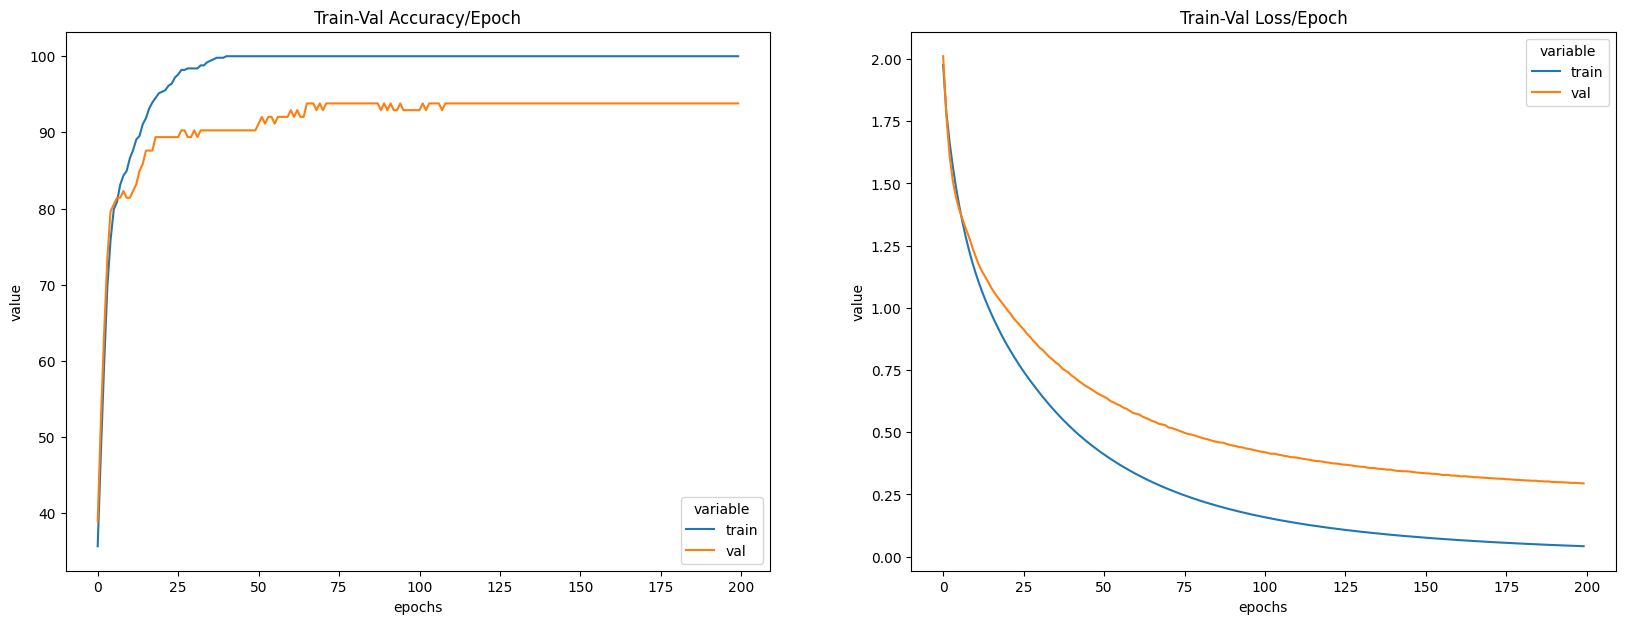

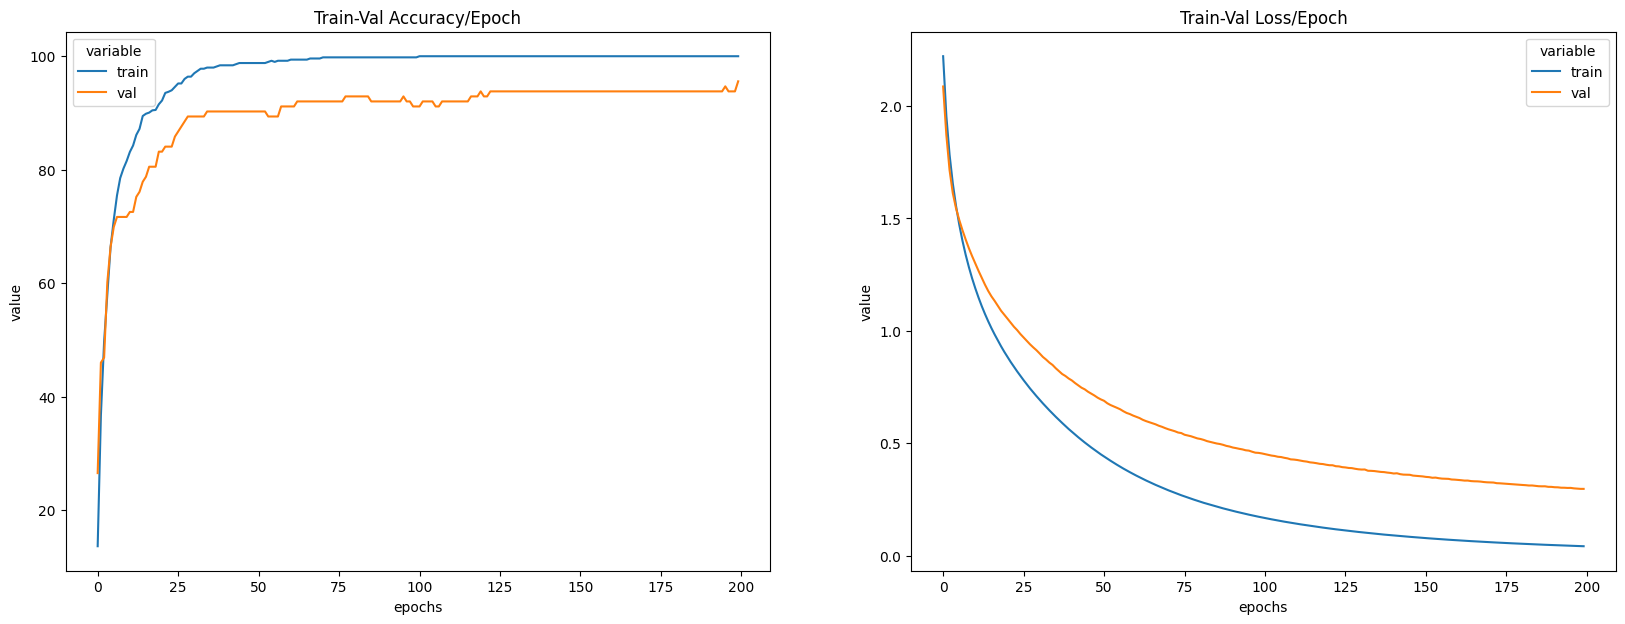

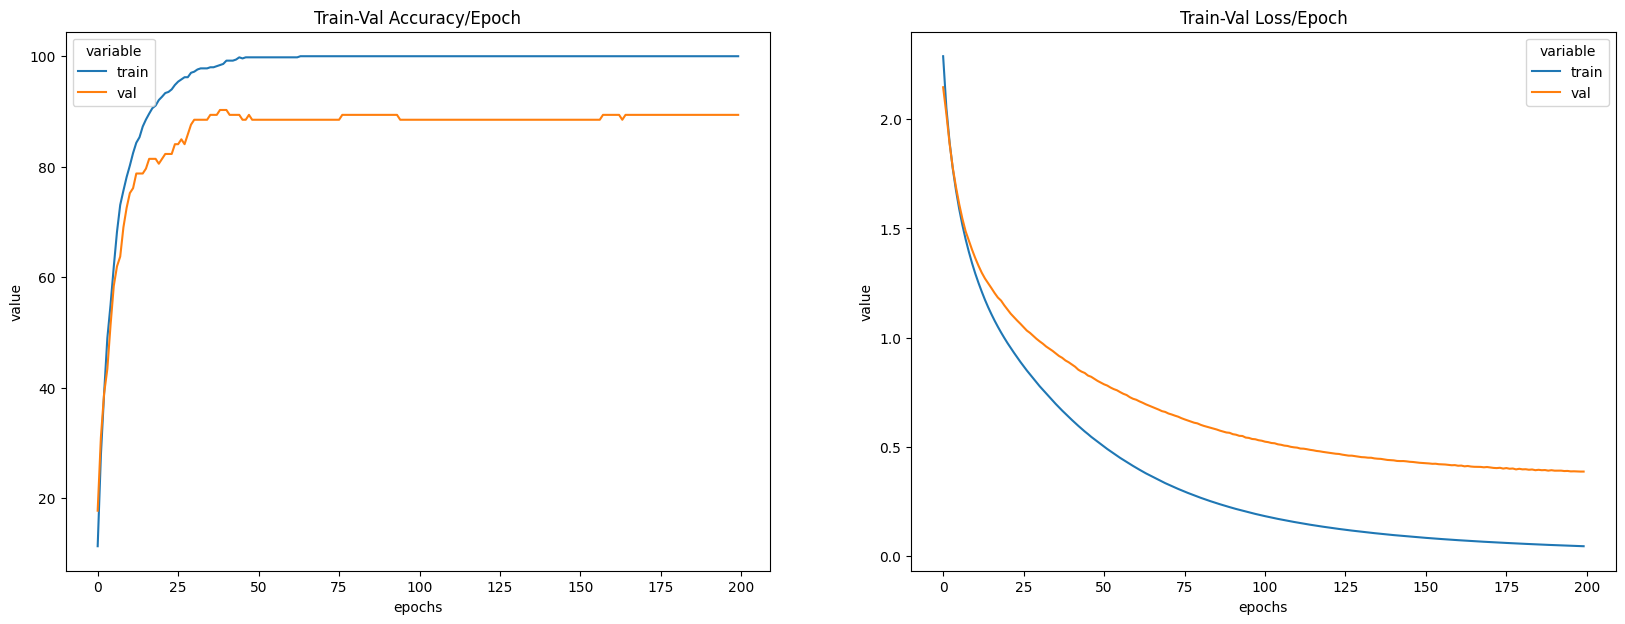

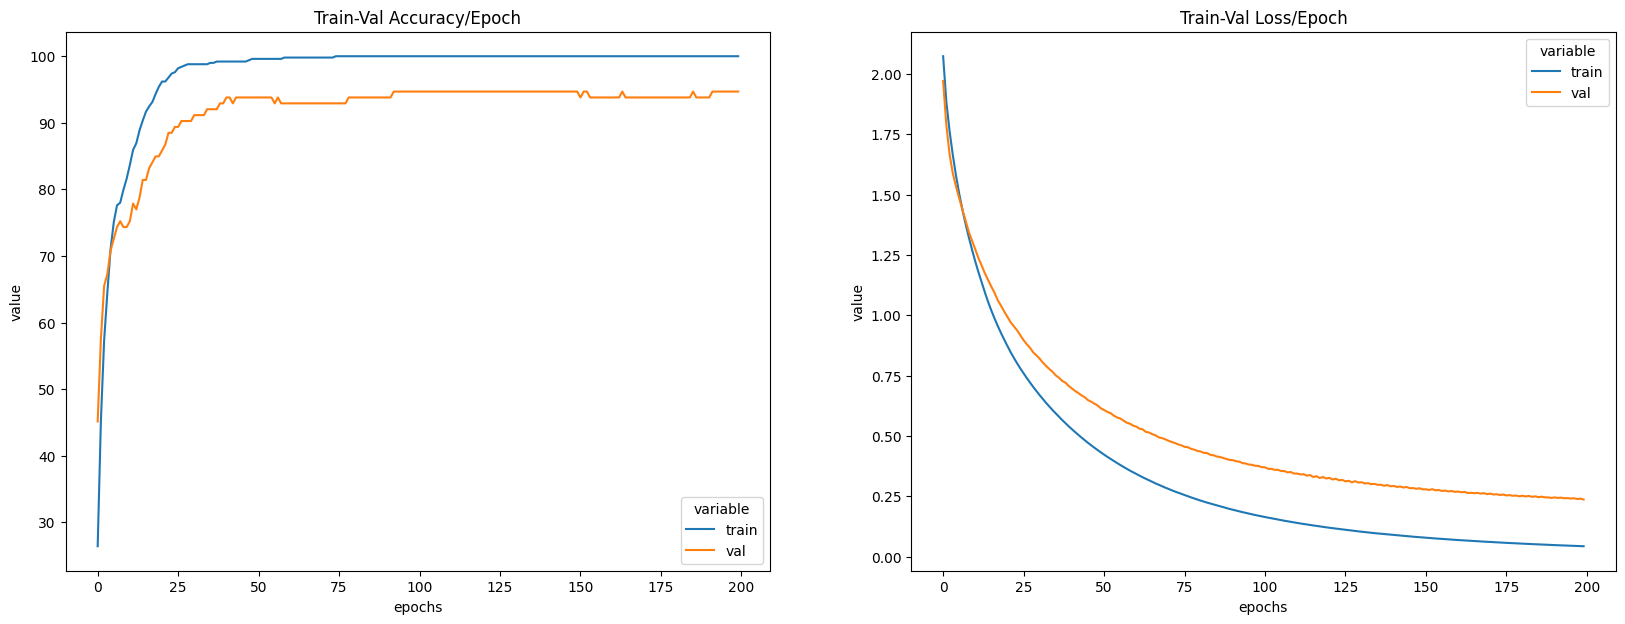

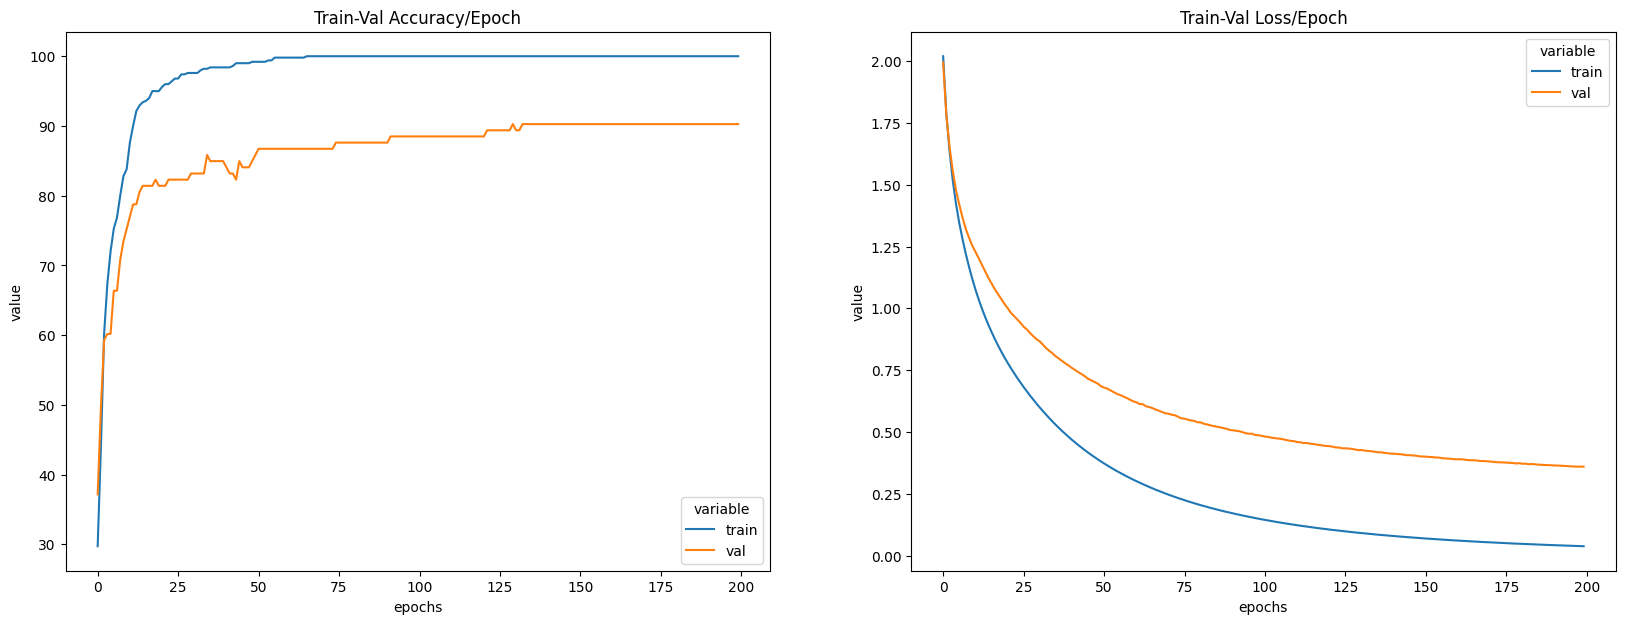

In [18]:
val_accuracies = []
val_avg = []


for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data, later this is called test data because the val data is subset of train
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    n_of_train_samples = int(math.ceil(len(y) * TRAIN_FRACTION))
    train_samples = sample(range(len(y)), n_of_train_samples)
    val_samples = [i for i in range(len(y)) if i not in train_samples]
    X_test = x_val
    y_test = y_val
    X_train = x[train_samples]
    y_train = y[train_samples]
    X_val = x[val_samples]
    y_val = y[val_samples]
    
    # create datasets
    train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    
    # create loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = DataLoader(dataset=val_dataset, batch_size=1)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1)
    
    # init model
    model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
    # define loss
    criterion = nn.CrossEntropyLoss()
    # define optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # loss recoder
    accuracy_stats = {
        'train': [],
        "val": []
    }
    loss_stats = {
        'train': [],
        "val": []
    }
    
    # train
    print("Begin training.")
    for e in tqdm(range(1, EPOCHS+1)):

        # TRAINING
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch, y_train_batch
            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)

            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = multi_acc(y_train_pred, y_train_batch)

            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()


        # VALIDATION    
        with torch.no_grad():

            val_epoch_loss = 0
            val_epoch_acc = 0

            model.eval()
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch, y_val_batch

                y_val_pred = model(X_val_batch)

                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = multi_acc(y_val_pred, y_val_batch)

                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()

        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # losses
    # Create dataframes
    train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    # Plot the dataframes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
    
    # predict
    y_pred_list = []
    with torch.no_grad():
        model.eval()
        for X_batch, _ in test_loader:
            X_batch = X_batch
            y_test_pred = model(X_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    
    df = classification_report(y_test, y_pred_list, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    print(f'Accuracy on the test set = {df["f1-score"]["accuracy"]}.')
    print('===========================')
    
print(f"Mean validation accuracy across 5 CV splits for a NN model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a NN model = {np.mean(np.array(val_avg))}.")


# Random forest

Adjusted from https://www.datacamp.com/tutorial/random-forests-classifier-python.

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
val_accuracies = []
val_avg = []
for i in range(5):
    print(f'Processing split = {i}...')
    df = adata.obs[[f'split{i}', DONOR]].drop_duplicates()
    train = list(df[df[f'split{i}'] == 'train'][DONOR])
    val = list(df[df[f'split{i}'] == 'val'][DONOR])
    # train data
    x = pd.DataFrame(adata_[adata_.obs_names.isin(train)].X).to_numpy()
    num_of_classes = len(adata_.obs[CONDITION].cat.categories)
    y = adata_[adata_.obs_names.isin(train)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y = y.to_numpy()
    print("Train shapes:")
    print(f"x.shape = {x.shape}")
    print(f"y.shape = {y.shape}")
    # val data
    x_val = pd.DataFrame(adata_[adata_.obs_names.isin(val)].X).to_numpy()
    y_val = adata_[adata_.obs_names.isin(val)].obs[CONDITION].cat.rename_categories(list(range(num_of_classes)))
    y_val = y_val.to_numpy()
    print("Val shapes:")
    print(f"x_val.shape = {x_val.shape}")
    print(f"y_val.shape = {y_val.shape}")
    # fit
    X = x
    Y = y
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X, Y)
    print(f'Train accuracy = {np.sum(clf.predict(X) == Y)/len(Y)}.')
    y_pred = clf.predict(x_val)
    val_accuracy = np.sum(y_pred == y_val)/len(y_val)
    
    df = classification_report(y_val, y_pred, output_dict=True)
    df = pd.DataFrame(df).T
    print('class report')
    print(df)
    
    val_accuracies.append(df["f1-score"]["accuracy"])
    val_avg.append(df["f1-score"]["weighted avg"])
    
    val_accuracy = df["f1-score"]["accuracy"]
    
    print(f'Val accuracy = {val_accuracy}.')
    print('===========================')


print(f"Mean validation accuracy across 5 CV splits for a random forest model = {np.mean(np.array(val_accuracies))}.")
print(f"Mean validation weighted avg across 5 CV splits for a random forest model = {np.mean(np.array(val_avg))}.")


Processing split = 0...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.9770723104056437.
class report
              precision    recall  f1-score     support
0              1.000000  0.333333  0.500000    3.000000
1              0.400000  0.250000  0.307692    8.000000
2              0.818182  0.692308  0.750000   13.000000
3              0.555556  0.833333  0.666667    6.000000
4              0.666667  1.000000  0.800000    4.000000
5              0.840426  0.940476  0.887640   84.000000
6              0.333333  0.333333  0.333333    3.000000
7              0.909091  0.526316  0.666667   19.000000
8              0.500000  0.500000  0.500000    2.000000
accuracy       0.788732  0.788732  0.788732    0.788732
macro avg      0.669250  0.601011  0.601333  142.000000
weighted avg   0.793696  0.788732  0.775634  142.000000
Val accuracy = 0.7887323943661971.
Processing split = 1...
Train shapes:
x.shape = (56

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

Train shapes:
x.shape = (567, 2000)
y.shape = (567,)
Val shapes:
x_val.shape = (142, 2000)
y_val.shape = (142,)
Train accuracy = 0.9682539682539683.
class report
              precision    recall  f1-score     support
0              1.000000  0.250000  0.400000    4.000000
1              0.428571  0.750000  0.545455    4.000000
2              0.666667  0.714286  0.689655   14.000000
3              0.428571  0.428571  0.428571    7.000000
4              1.000000  0.500000  0.666667    4.000000
5              0.831683  0.933333  0.879581   90.000000
6              1.000000  0.250000  0.400000    4.000000
7              0.750000  0.500000  0.600000   12.000000
8              0.000000  0.000000  0.000000    3.000000
accuracy       0.774648  0.774648  0.774648    0.774648
macro avg      0.678388  0.480688  0.512214  142.000000
weighted avg   0.773937  0.774648  0.753986  142.000000
Val accuracy = 0.7746478873239436.
Processing split = 3...
Train shapes:
x.shape = (567, 2000)
y.shape = (567,

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w